In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('../input/pytorch-optimizers/')

In [2]:
import os
import gc
import cv2
import copy
import time
import yaml
import random
import shutil
import warnings
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob as glob_file
from tqdm import tqdm
from PIL import Image, ImageDraw
from shutil import copyfile
from IPython.core.display import Video, display
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold

import timm
import torch
from fastai.vision.all import *

warnings.simplefilter('ignore')
pd.set_option("max_columns", 150)
pd.set_option('display.max_rows', 150)

In [3]:
# https://github.com/rwightman/pytorch-image-models/blob/master/results/results-imagenet.csv
# timm.list_models(pretrained=True)

# Configuration

In [4]:
CFG = {
    "save_prev"     : [True, ["petfinder_*.pth"]],
    "seed"          : 42,
    'device'        : "cuda:0" if torch.cuda.is_available() else "cpu",
    "input_img"     : '../input/petfinder-pawpularity-score/train/',
    "input_path"    : '../input/petfinder-smogn-dataset/train_drop_duplicated.csv',
    "output_path"   : './',
    "pretrain"      : "../input/petfinder-fastai-semisupervised-models/petfinder_efnet_binary_ss_fastai_4.pth",
    "save_name"     : "petfinder_effnet_binary_fastai_ss",
    "model"         : "tf_efficientnet_b5_ns",
    "loss"          : "binary",
    "size"          : 512,
    "fold"          : 4,
    "batch_size"    : 16,
    "epochs"        : 15,
    "n_data"        : 16*50,  # Batch * step
    "mixup_ratio"   : 0,
    "lr"            : 1e-6,
    "accum_iter"    : 2,
    'early_stopping': 3,
    'verbose_step'  : 1,
    "num_workers"   : 4
}

CFG

{'save_prev': [True, ['petfinder_*.pth']],
 'seed': 42,
 'device': 'cuda:0',
 'input_img': '../input/petfinder-pawpularity-score/train/',
 'input_path': '../input/petfinder-smogn-dataset/train_drop_duplicated.csv',
 'output_path': './',
 'pretrain': '../input/petfinder-fastai-semisupervised-models/petfinder_efnet_binary_ss_fastai_4.pth',
 'save_name': 'petfinder_effnet_binary_fastai_ss',
 'model': 'tf_efficientnet_b5_ns',
 'loss': 'binary',
 'size': 512,
 'fold': 4,
 'batch_size': 16,
 'epochs': 15,
 'n_data': 800,
 'mixup_ratio': 0,
 'lr': 1e-06,
 'accum_iter': 2,
 'early_stopping': 3,
 'verbose_step': 1,
 'num_workers': 4}

In [5]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def softmax(x):
    max = np.max(x,axis=1,keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x,axis=1,keepdims=True)
    return e_x / sum 

def seed_everything(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG["seed"])

In [6]:
if CFG['save_prev'][0]:
    for file_pattern in CFG['save_prev'][1]:
        for f in glob_file(f"../input/petfinder-fastai-models-pseudolabel-1/{file_pattern}"):
            filename = os.path.basename(f)
            print(filename)
            !cp {f} ./{filename}

petfinder_effnet_binary_fastai_1.pth
petfinder_effnet_binary_fastai_3.pth
petfinder_effnet_binary_fastai_0.pth
petfinder_effnet_binary_fastai_2.pth


# Load data

In [7]:
df_train = pd.read_csv(CFG['input_path'])
df_train["path"] = [f"{CFG['input_img']}{i}.jpg" for i in df_train.Id]
df_train["Pawclass"] = df_train.Pawpularity / 100

num_bins = int(np.ceil(2*((len(df_train))**(1./3))))
df_train['bins'] = pd.cut(df_train['Pawclass'], bins=num_bins, labels=False)

meta_features = [c for c in df_train.columns if c not in ["Id","path", "Pawpularity","Pawclass","bins"]]

print(meta_features)
print(df_train.shape)
df_train.head(2)

['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
(9860, 17)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,Pawclass,bins
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/0007de18844b0dbbb5e1f607da0606e0.jpg,0.63,26
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/0009c66b9439883ba2750fb825e1d7db.jpg,0.42,17


In [8]:
kfold = StratifiedKFold(n_splits=CFG['fold'], random_state=CFG["seed"], shuffle=True)
df_train["fold"] = 0
for i, (_, train_index) in enumerate(kfold.split(df_train.index, df_train['bins'])):
    df_train.loc[train_index, "fold"] = i
df_train['fold'] = df_train['fold'].astype('int')

df_train.fold.value_counts()

3    2465
1    2465
2    2465
0    2465
Name: fold, dtype: int64

<AxesSubplot:>

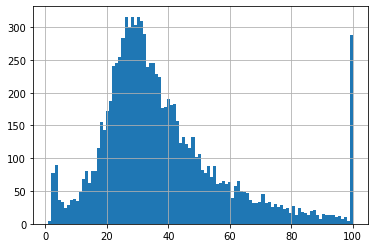

In [9]:
df_train.Pawpularity.hist(bins=100)

# Define model

In [10]:
def prepare_dataloader(df, fold):
    df = df.copy()
    df['is_valid'] = (df['fold'] == fold)
    
    label_col  = "Pawclass" if CFG["loss"] == "binary" else "Pawpularity"
    dataloader = ImageDataLoaders.from_df(
        df,
        valid_col='is_valid',
        seed=CFG["seed"],
        fn_col='path',
        label_col=label_col,
        y_block=RegressionBlock,
        bs=CFG['batch_size'],
        n=CFG["n_data"],
        shuffle=True,
        num_workers=CFG['num_workers'],
        item_tfms=Resize(CFG['size']),
        batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])
    )
    return dataloader

def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [11]:
class Model(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, 1)

    def forward(self, x):
        output = self.model(x)
        return output

class SwinModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model   = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=3)
        num_features = self.model.num_features
        self.linear  = nn.Linear(num_features, 1)

    def forward(self, x):
        x = self.model(x)
        output = self.linear(x)
        return output

def get_learner(df, fold):
    dataloader = prepare_dataloader(df, fold)
    if CFG['pretrain'] is None:
        model = Model(CFG["model"], pretrained=True)
    else:
        model = Model(CFG["model"], pretrained=False)
        model.load_state_dict(torch.load(CFG['pretrain']))
    learner = Learner(
        dataloader,
        model,
        loss_func=BCEWithLogitsLossFlat(),
        metrics=AccumMetric(petfinder_rmse)).to_fp16()
    return learner

In [12]:
# Ref: https://fastai1.fast.ai/callbacks.lr_finder.html
# get_learner(df_train, fold=0).lr_find(end_lr=3e-2)

# Run training

In [13]:
all_preds = []

for fold in range(CFG["fold"]):
    learn = get_learner(df_train, fold)
    learn.fit_one_cycle(
        CFG["epochs"],
        CFG["lr"],
        cbs=[SaveModelCallback(),
             EarlyStoppingCallback(monitor='petfinder_rmse',
                                   comp=np.less,
                                   patience=CFG['early_stopping'])]
    )
    shutil.move("./models/model.pth", f"{CFG['output_path']}{CFG['save_name']}_{fold}.pth")
    
    del learn
    torch.cuda.empty_cache()
    gc.collect()
    
!rm -rf ./models

epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.637043,0.634985,16.917128,02:21
1,0.637347,0.634996,16.919142,02:12
2,0.636368,0.634927,16.909452,02:13
3,0.636239,0.634802,16.893499,02:12
4,0.635704,0.634701,16.879595,02:13
5,0.635591,0.634635,16.872259,02:13
6,0.635597,0.634413,16.841524,02:13
7,0.635673,0.634345,16.832867,02:13
8,0.636243,0.634393,16.839653,02:13
9,0.633447,0.634357,16.834600,02:12


Better model found at epoch 0 with valid_loss value: 0.6349853277206421.
Better model found at epoch 2 with valid_loss value: 0.6349267363548279.
Better model found at epoch 3 with valid_loss value: 0.6348020434379578.
Better model found at epoch 4 with valid_loss value: 0.6347007751464844.
Better model found at epoch 5 with valid_loss value: 0.6346345543861389.
Better model found at epoch 6 with valid_loss value: 0.6344127655029297.
Better model found at epoch 7 with valid_loss value: 0.6343452334403992.
Better model found at epoch 10 with valid_loss value: 0.63429856300354.
Better model found at epoch 12 with valid_loss value: 0.6341819763183594.


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.637090,0.636475,17.075413,02:13
1,0.637862,0.636537,17.082491,02:12
2,0.638228,0.636265,17.048178,02:11
3,0.637939,0.636330,17.056971,02:13
4,0.636646,0.636489,17.078690,02:13
5,0.637285,0.636250,17.048088,02:12
6,0.636335,0.636130,17.031816,02:13
7,0.636097,0.636371,17.063511,02:12
8,0.636354,0.636337,17.059626,02:12
9,0.636688,0.636038,17.020403,02:12


Better model found at epoch 0 with valid_loss value: 0.6364746689796448.
Better model found at epoch 2 with valid_loss value: 0.6362650990486145.
Better model found at epoch 5 with valid_loss value: 0.636250376701355.
Better model found at epoch 6 with valid_loss value: 0.6361302137374878.
Better model found at epoch 9 with valid_loss value: 0.6360381841659546.
No improvement since epoch 9: early stopping


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.636789,0.631140,16.320730,02:13
1,0.638270,0.630912,16.292643,02:12
2,0.640310,0.630858,16.286602,02:12
3,0.640527,0.630769,16.272884,02:13
4,0.638347,0.630825,16.279636,02:13
5,0.638393,0.630876,16.288824,02:13
6,0.638608,0.630585,16.249084,02:12
7,0.636981,0.630624,16.256193,02:12
8,0.636265,0.630538,16.241451,02:11
9,0.637245,0.630517,16.241983,02:11


Better model found at epoch 0 with valid_loss value: 0.631140410900116.
Better model found at epoch 1 with valid_loss value: 0.630911648273468.
Better model found at epoch 2 with valid_loss value: 0.6308581233024597.
Better model found at epoch 3 with valid_loss value: 0.6307692527770996.
Better model found at epoch 6 with valid_loss value: 0.6305851340293884.
Better model found at epoch 8 with valid_loss value: 0.6305384039878845.
Better model found at epoch 9 with valid_loss value: 0.6305174827575684.
Better model found at epoch 10 with valid_loss value: 0.6303712129592896.
No improvement since epoch 10: early stopping


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.637489,0.635110,16.913961,02:13
1,0.636458,0.635094,16.913055,02:12
2,0.638649,0.634918,16.890318,02:12
3,0.638126,0.634797,16.874161,02:11
4,0.639368,0.634783,16.873316,02:11
5,0.638017,0.634715,16.864052,02:11
6,0.636554,0.634622,16.853086,02:12
7,0.635737,0.634610,16.849644,02:12
8,0.635236,0.634662,16.857853,02:11
9,0.634129,0.634621,16.851658,02:12


Better model found at epoch 0 with valid_loss value: 0.6351096034049988.
Better model found at epoch 1 with valid_loss value: 0.6350937485694885.
Better model found at epoch 2 with valid_loss value: 0.6349181532859802.
Better model found at epoch 3 with valid_loss value: 0.6347973942756653.
Better model found at epoch 4 with valid_loss value: 0.6347833275794983.
Better model found at epoch 5 with valid_loss value: 0.6347151398658752.
Better model found at epoch 6 with valid_loss value: 0.6346219778060913.
Better model found at epoch 7 with valid_loss value: 0.6346096396446228.
Better model found at epoch 10 with valid_loss value: 0.6345424652099609.
Better model found at epoch 11 with valid_loss value: 0.6344925761222839.
Better model found at epoch 12 with valid_loss value: 0.634480893611908.
Better model found at epoch 13 with valid_loss value: 0.6344224214553833.
